# Section 1 : Data Loading

In [1]:
# for data manipulation
import pandas as pd
import numpy as np
# for visualization requirement
import seaborn as sns
import matplotlib.pyplot as plt

## Architecture - Data loading and merging 

In [2]:
# 1. Loading Main Application Data
df = pd.read_csv("application_train.csv")

# 2. Load Bureau Data (External History - Helpful for Non-Bankers)
bureau = pd.read_csv("bureau.csv")
bureau_agg = bureau.groupby("SK_ID_CURR").agg({
    "SK_ID_BUREAU" : "count",
    "CREDIT_DAY_OVERDUE" : "mean"
}).rename(columns={"SK_ID_BUREAU" : "BUREAU_LOAN_COUNT" , "CREDIT_DAY_OVERDUE" : "BUREAU_AVG_OVERDUE"})

# 3. Load Installments (Repayment Behaviour)
install = pd.read_csv("installments_payments.csv")
install["DAYS_LATE"] = install["DAYS_ENTRY_PAYMENT"] - install["DAYS_INSTALMENT"]
install["DAYS_LATE"] = install["DAYS_LATE"].apply(lambda x : x if x > 0 else 0)

install_agg = install.groupby("SK_ID_CURR")["DAYS_LATE"].agg(["mean","max"])
install_agg.columns = ["AVG_DAYS_LATE" , "MAX_DAYS_LATE"]

# Merging
df = df.merge(bureau_agg, on="SK_ID_CURR", how = "left")
df = df.merge(install_agg, on = "SK_ID_CURR" , how = "left")

In [3]:
df.head() # preview of the dataframe

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_LOAN_COUNT,BUREAU_AVG_OVERDUE,AVG_DAYS_LATE,MAX_DAYS_LATE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.000000,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.954545,12.0


In [4]:
df.isnull().sum() # to find the count of missing/NaN values

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_YEAR    41519
BUREAU_LOAN_COUNT             44020
BUREAU_AVG_OVERDUE            44020
AVG_DAYS_LATE                 15868
MAX_DAYS_LATE                 15868
Length: 126, dtype: int64

## Features derived from external/alternative data

In [5]:
new_alter_features = ["BUREAU_LOAN_COUNT","BUREAU_AVG_OVERDUE","AVG_DAYS_LATE","MAX_DAYS_LATE"]
# filling NaNs with 0 (Logically : Missing Value = No History = 0)
df[new_alter_features] = df[new_alter_features].fillna(0)

# Section 2 : EDA - Exploratory Data Analysis

## Target Distribution

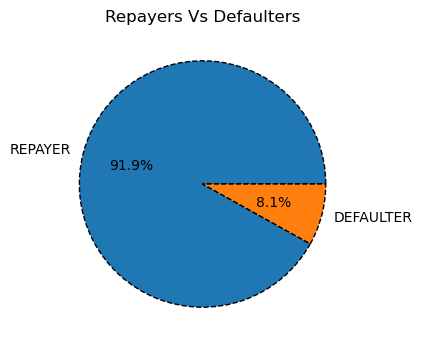

In [6]:
plt.figure(figsize = (6,4))
plt.pie(df["TARGET"].value_counts() , labels = ["REPAYER","DEFAULTER"] , autopct = "%1.1f%%",wedgeprops={'edgecolor' : 'black' , 'linewidth' : 1,'linestyle' : "--"})
plt.title("Repayers Vs Defaulters")
plt.show()

## Bureau History

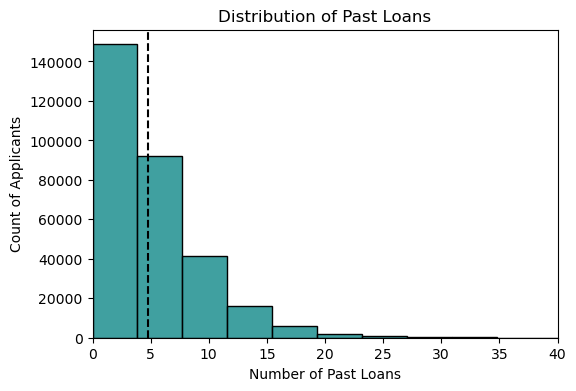

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(
    data = df["BUREAU_LOAN_COUNT"],
    bins = 30,
    color = "teal"
)
plt.title("Distribution of Past Loans")
plt.xlabel("Number of Past Loans")
plt.ylabel("Count of Applicants")
plt.xlim(0,40)
mean = df["BUREAU_LOAN_COUNT"].mean()
plt.axvline(x=mean,color = "black",linestyle = "--") # where the mean of plot data lies
plt.show()

## Financial Maturity

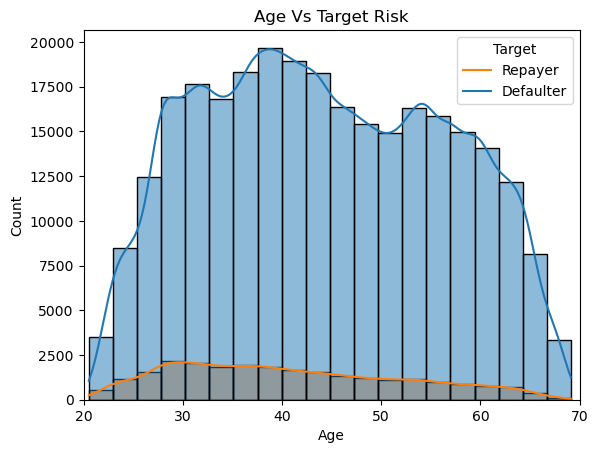

In [8]:
df["AGE_YEARS"] = df["DAYS_BIRTH"] / -365 # why convert days birth (-ve) to (+ve)
sns.histplot(data = df ,x = "AGE_YEARS" , hue = "TARGET", kde = True,bins = 20)
plt.title("Age Vs Target Risk")
plt.xlabel("Age")
plt.xlim(20,70)
plt.legend(title = "Target",labels = ["Repayer","Defaulter"])
plt.show()

## Income Distribution (Core Credit Factor)

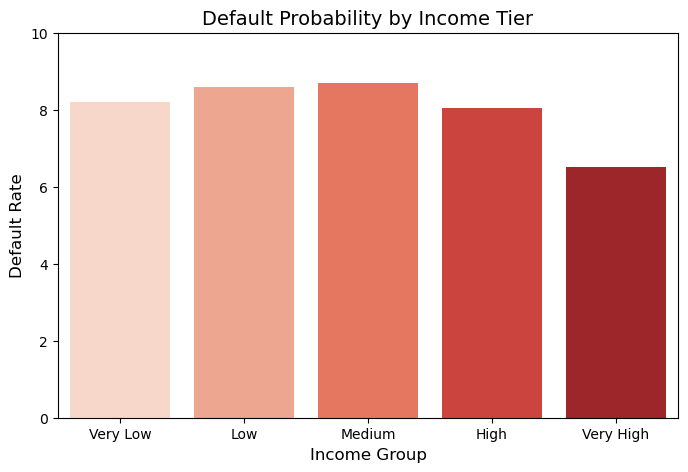

In [9]:
df["INCOME_BIN"] = pd.qcut(df["AMT_INCOME_TOTAL"] , q=5 , labels = ["Very Low","Low","Medium","High","Very High"])
# sinced income was skewed we separated it into 5 bins (low to high)
income_risk = df.groupby("INCOME_BIN" , observed = False)["TARGET"].mean().reset_index()
income_risk["TARGET"] = income_risk["TARGET"] * 100

plt.figure(figsize=(8,5))
sns.barplot(x="INCOME_BIN" , y="TARGET" ,hue = "INCOME_BIN",data = income_risk,palette = "Reds",legend = False)
plt.title("Default Probability by Income Tier",fontsize=14)
plt.ylabel("Default Rate",fontsize = 12)
plt.xlabel("Income Group",fontsize=12)
plt.ylim(0,10)
plt.show()

## Repayment Vs Default

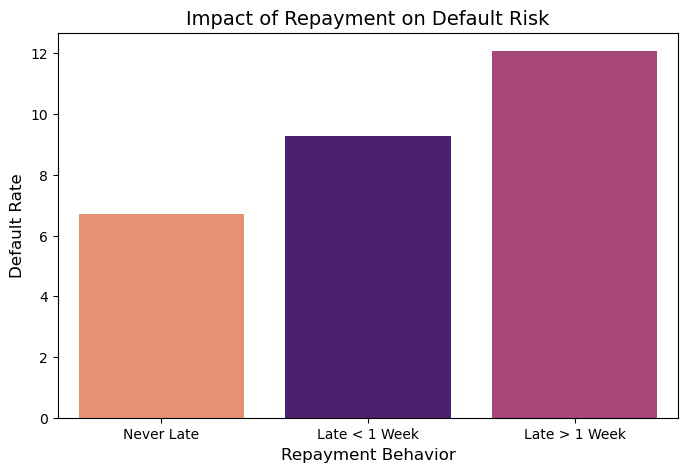

In [10]:
def categorize_lateness(days):
    if days <= 0: return "Never Late"
    elif days <= 7: return "Late < 1 Week"
    else: return "Late > 1 Week"
# into 3 categories so it is easier to understand
df["LATE_CATEGORY"] = df["AVG_DAYS_LATE"].apply(categorize_lateness)
late_risk = df.groupby("LATE_CATEGORY", observed=False)["TARGET"].mean().reset_index()
late_risk["TARGET"] = late_risk["TARGET"] * 100

plt.figure(figsize=(8,5))
order = ["Never Late", "Late < 1 Week", "Late > 1 Week"]
sns.barplot(x="LATE_CATEGORY", y="TARGET", hue = "LATE_CATEGORY", data=late_risk, order=order, palette="magma",legend = False)
plt.title("Impact of Repayment on Default Risk", fontsize=14)
plt.ylabel("Default Rate",fontsize=12)
plt.xlabel("Repayment Behavior",fontsize = 12)
plt.show()

## Education Level Vs Default Rate

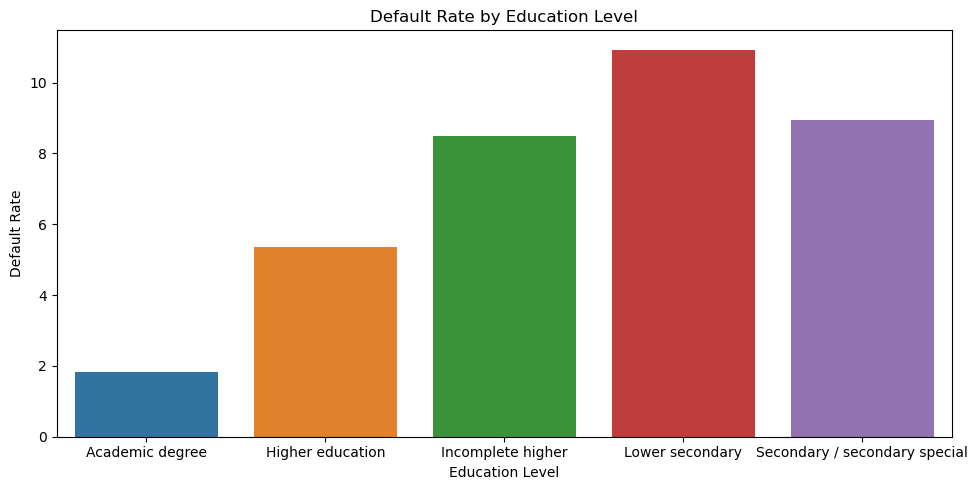

In [11]:
edu_risk = df.groupby("NAME_EDUCATION_TYPE",observed = False)["TARGET"].mean().reset_index()
edu_risk["TARGET"] = edu_risk["TARGET"] * 100
# education is a socio-economic factor which shows direct relation with Default rate
plt.figure(figsize = (10,5))
sns.barplot(x = "NAME_EDUCATION_TYPE" , y = "TARGET",hue = "NAME_EDUCATION_TYPE",legend = False,data = edu_risk)
plt.title("Default Rate by Education Level")
plt.ylabel("Default Rate")
plt.xlabel("Education Level")
plt.tight_layout()
plt.show()

# Section 3 : Preprocessing & Feature Engineering

## Feature Engineering

In [12]:
# High PTI = High Default Risk.
df["PAYMENT_TO_INCOME"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
# Credit-to-Income Ratio
df["CREDIT_TO_INCOME"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]
# Longer loans usually carry higher risk over time.
df["CREDIT_TERM"] = df["AMT_CREDIT"] / df["AMT_ANNUITY"]

## Handling Missing Values

In [13]:
# defining X and y
X = df.drop(columns = ["SK_ID_CURR","TARGET","CODE_GENDER", "NAME_FAMILY_STATUS","LATE_CATEGORY", "INCOME_BIN"])
# dropping features that do not affect while training the model
y = df["TARGET"]

In [14]:
# numerical and categorical columns
num_cols = X.select_dtypes(include = "number").columns
cat_cols = X.select_dtypes(include = "object").columns

In [15]:
num_cols

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'BUREAU_LOAN_COUNT', 'BUREAU_AVG_OVERDUE', 'AVG_DAYS_LATE',
       'MAX_DAYS_LATE', 'AGE_YEARS', 'PAYMENT_TO_INCOME', 'CREDIT_TO_INCOME',
       'CREDIT_TERM'],
      dtype='object', length=112)

In [16]:
cat_cols

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

## Simple Imputer 

In [17]:
# handle the missing values and filling them accordingly
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy = "median") # median for numerical values
cat_imputer = SimpleImputer(strategy = "most_frequent") # most frequent for categorical values
# applying them to dataframe
X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

## One Hot Encoding

In [18]:
# categorical data is converted into multiple columns with numerical values
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False,drop = "first")
encoded = ohe.fit_transform(X[cat_cols])
encoded_df = pd.DataFrame(encoded,columns=ohe.get_feature_names_out(cat_cols),index=X.index)
# Dropping original categorical columns
X = X.drop(columns=cat_cols)
# merge encoded columns
X = pd.concat([X, encoded_df], axis=1)
X.shape

(307511, 229)

In [19]:
X.head() # encoded dataframe for training

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Correlation Heatmap

In [20]:
temp_df = X.copy()
temp_df["TARGET"] = y
corr_matrix = temp_df.corr()
target_corr = corr_matrix["TARGET"].abs().sort_values(ascending=False)
top_20 = target_corr.index[1:21]

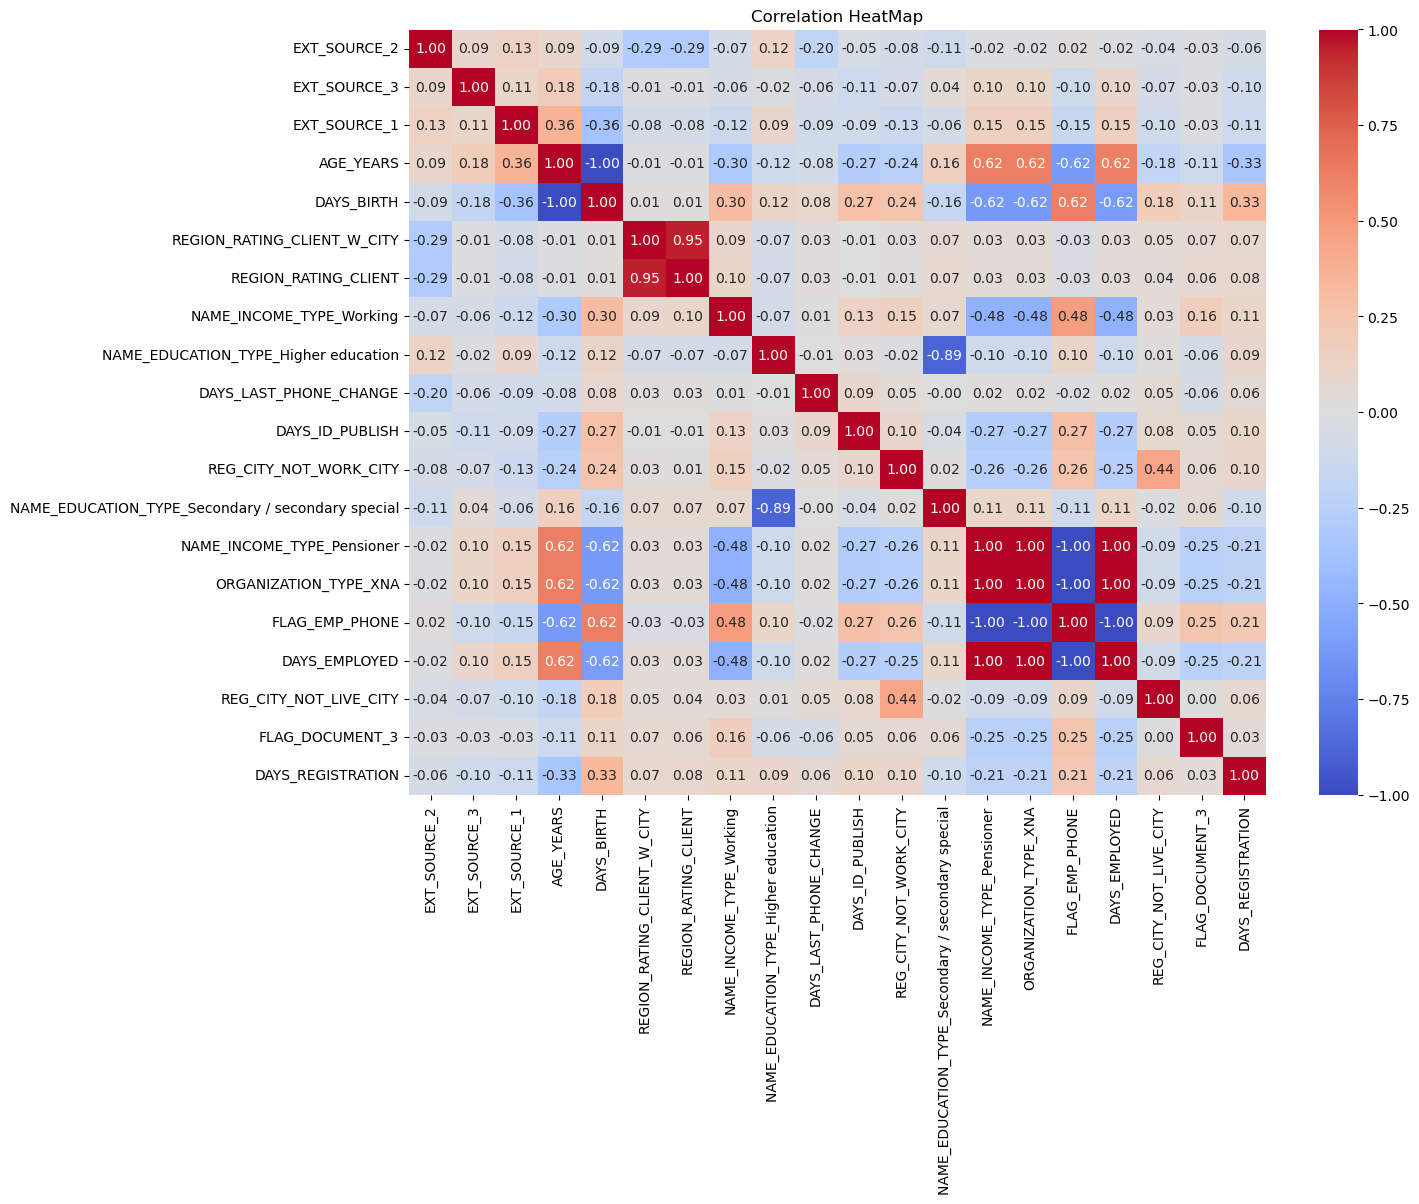

In [21]:
# top 20 fetaures as all features gets us a highly clustered heatmap
plt.figure(figsize = (15,12))
sns.heatmap(temp_df[top_20].corr(), cmap ="coolwarm",annot = True,fmt = ".2f")
plt.tight_layout()
plt.title("Correlation HeatMap")
plt.show()

# Section 4 : Model Training

## Train-Test-Split

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = y,random_state = 42)

## Scaling for models like Logistic Regression

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# only .transform on X_test to avoid the model from cheating

## SMOTE

In [24]:
# to avoid imbalance and balance the training data so the model does not favor majority
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_bal,y_train_bal = smote.fit_resample(X_train_scaled,y_train)
# smote is only done on training data

## Logistic Regression - Baseline

### Training

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,confusion_matrix,roc_auc_score
# imported the baseline model and evalution parameters
log_model = LogisticRegression(max_iter = 1_000,random_state = 42)
log_model.fit(X_train_bal,y_train_bal)
# training the model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Testing

In [26]:
# predicting using our trained model
y_train_pred_lr = log_model.predict(X_train_bal)
y_test_pred_lr = log_model.predict(X_test_scaled)
# predict returns 0 or 1 using default threshold 0.5
y_train_prob_lr = log_model.predict_proba(X_train_bal)[:,1] # column 0 -> repayer and column 1 -> defaulter
y_test_prob_lr = log_model.predict_proba(X_test_scaled)[:,1]
# prdict_prob returns probability between 0 and 1

### Evaluation

ROC - AUC Score :  0.7402319259329795
Recall Score :  0.6559919436052366
Precision Score :  0.16120570184121957
F1 Score :  0.25881044141602766
Training Accuracy :  0.7095862001874879
Tresting Accuracy :  0.6966814626928768


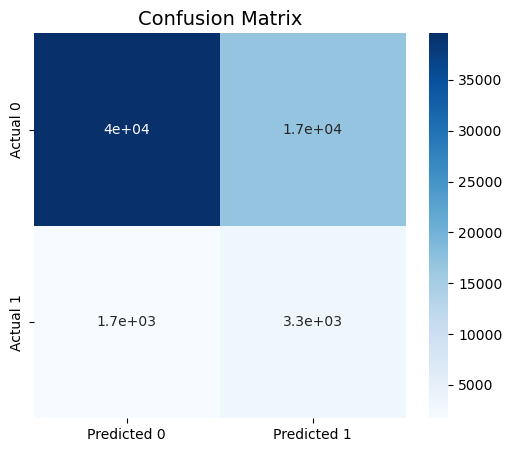

In [27]:
# ROC - AUC
print("ROC - AUC Score : ",roc_auc_score(y_test,y_test_prob_lr))
# Recall - To check if defaulters are not approved
print("Recall Score : ",recall_score(y_test,y_test_pred_lr))
# Precision - To check if repayers are not disapproved
print("Precision Score : ",precision_score(y_test,y_test_pred_lr))
# F1 Score
print("F1 Score : ",f1_score(y_test,y_test_pred_lr))
# Accuracy - to check for overfitting
print("Training Accuracy : ",accuracy_score(y_train_bal,y_train_pred_lr))
print("Tresting Accuracy : ",accuracy_score(y_test,y_test_pred_lr))
# Confusion Matrix
cm = confusion_matrix(y_test,y_test_pred_lr)
plt.figure(figsize = (6,5))
sns.heatmap(cm,annot = True,cmap = "Blues",xticklabels=["Predicted 0","Predicted 1"],yticklabels=["Actual 0","Actual 1"])
plt.title("Confusion Matrix",fontsize=14)
plt.show()

## XGBOOST - Stable and Robust

In [28]:
# we use scale_pos_weight as decision trees don't depend on distance
negative = y_train.value_counts()[0]
positive = y_train.value_counts()[1]
scale_pos_weight = negative/positive

### Training

In [29]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score,confusion_matrix,roc_auc_score
xgb_model = xgb.XGBClassifier(
    n_estimators = 300,
    max_depth = 6,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    min_child_weight = 5,
    scale_pos_weight = scale_pos_weight,
    random_state = 42,
    eval_metric = "logloss"
)
# training model
xgb_model.fit(X_train,y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### Testing

In [30]:
# predicting using our trained model
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)
# predict returns 0 or 1 using default threshold 0.5
y_train_prob_xgb = xgb_model.predict_proba(X_train)[:,1] # column 0 -> repayer and column 1 -> defaulter
y_test_prob_xgb = xgb_model.predict_proba(X_test)[:,1]
# prdict_prob returns probability between 0 and 1

### Evaluation

ROC - AUC Score :  0.7700121035440093
Recall Score :  0.6622356495468278
Precision Score :  0.18200941046221977
F1 Score :  0.2855405992184108
Training Accuracy :  0.7324683348779735
Tresting Accuracy :  0.7324683348779735


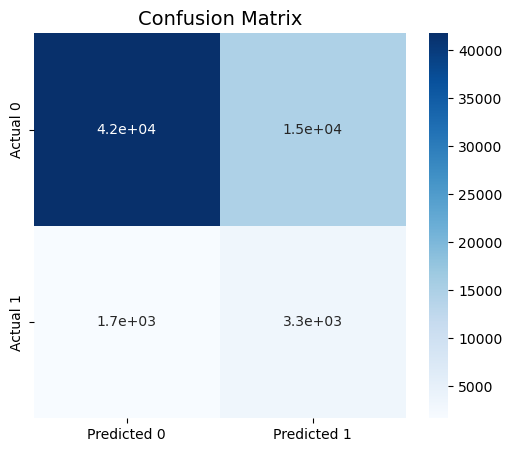

In [31]:
# ROC - AUC
print("ROC - AUC Score : ",roc_auc_score(y_test,y_test_prob_xgb))
# Recall - To check if defaulters are not approved
print("Recall Score : ",recall_score(y_test,y_test_pred_xgb))
# Precision - To check if repayers are not disapproved
print("Precision Score : ",precision_score(y_test,y_test_pred_xgb))
# F1 Score
print("F1 Score : ",f1_score(y_test,y_test_pred_xgb))
# Accuracy - to check for overfitting
print("Training Accuracy : ",accuracy_score(y_test,y_test_pred_xgb))
print("Tresting Accuracy : ",accuracy_score(y_test,y_test_pred_xgb))
# Confusion Matrix
cm = confusion_matrix(y_test,y_test_pred_xgb)
plt.figure(figsize = (6,5))
sns.heatmap(cm,annot = True,cmap = "Blues",xticklabels=["Predicted 0","Predicted 1"],yticklabels=["Actual 0","Actual 1"])
plt.title("Confusion Matrix",fontsize=14)
plt.show()

## Comparsion between LogisticRegression and XGBoost

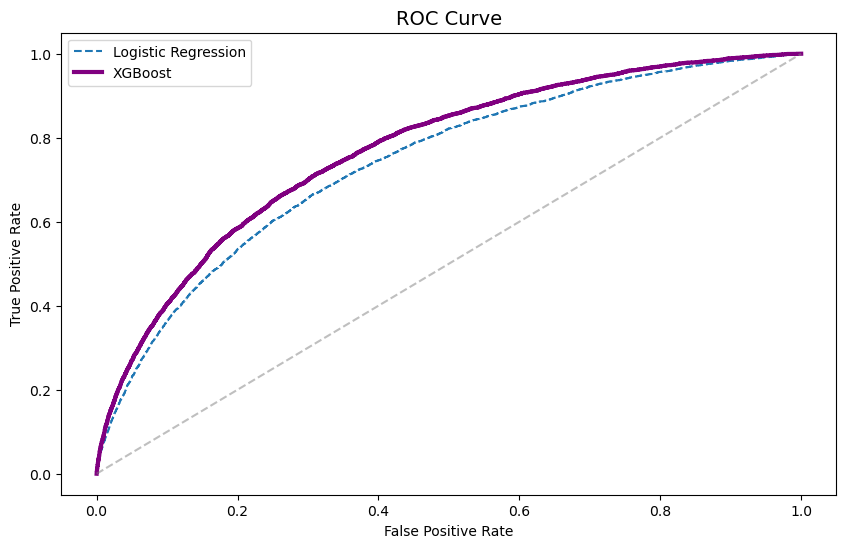

In [32]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(10, 6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_prob_lr) # fpr -> false positive rate
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_prob_xgb)# tpr- > true positive rate
# parameters used for the curve
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression", linestyle="--")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost", linewidth=3, color="purple")
plt.plot([0,1], [0, 1],linestyle = "--", alpha=0.5,color="grey")
plt.title("ROC Curve", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## LightGBM - Faster & Leaf-wise tree growth for complex patterns

### Cleaning

In [33]:
import re 
X1 = X.copy()
X1 = X1.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X1_train, X1_test, y_train_clean, y_test_clean = train_test_split(
    X1, y, test_size=0.2,stratify = y ,random_state=42)

### Training

In [34]:
import lightgbm as lgb
lgb_model= lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    class_weight="balanced",
    metric = "binary_logloss",
    random_state=42
)
lgb_model.fit(X1_train,y_train)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13193
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 221
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Testing

In [35]:
y_train_pred_lgb = lgb_model.predict(X1_train)
y_test_pred_lgb = lgb_model.predict(X1_test)

y_train_prob_lgb = lgb_model.predict_proba(X1_train)[:,1]
y_test_prob_lgb = lgb_model.predict_proba(X1_test)[:,1]

### Evalution

ROC - AUC Score :  0.7706522259160546
Recall Score :  0.6797583081570997
Precision Score :  0.17800632911392406
F1 Score :  0.28213166144200624
Training Accuracy :  0.7207453294961221
Tresting Accuracy :  0.7207453294961221


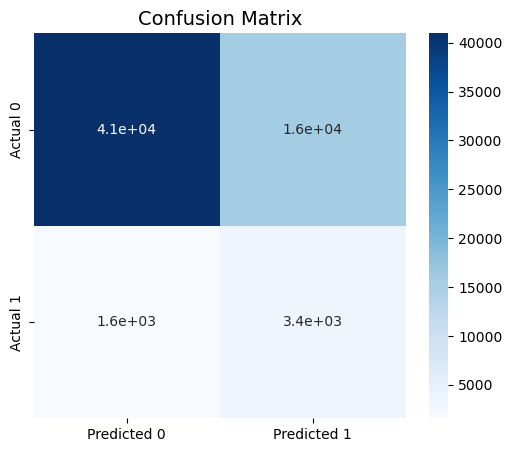

In [36]:
# ROC - AUC
print("ROC - AUC Score : ",roc_auc_score(y_test,y_test_prob_lgb))
# Recall - To check if defaulters are not approved
print("Recall Score : ",recall_score(y_test,y_test_pred_lgb))
# Precision - To check if repayers are not disapproved
print("Precision Score : ",precision_score(y_test,y_test_pred_lgb))
# F1 Score
print("F1 Score : ",f1_score(y_test,y_test_pred_lgb))
# Accuracy - to check for overfitting
print("Training Accuracy : ",accuracy_score(y_test,y_test_pred_lgb))
print("Tresting Accuracy : ",accuracy_score(y_test,y_test_pred_lgb))
# Confusion Matrix
cm = confusion_matrix(y_test,y_test_pred_lgb)
plt.figure(figsize = (6,5))
sns.heatmap(cm,annot = True,cmap = "Blues",xticklabels=["Predicted 0","Predicted 1"],yticklabels=["Actual 0","Actual 1"])
plt.title("Confusion Matrix",fontsize=14)
plt.show()

## Comparsion between LogisticRegression and LightGBM

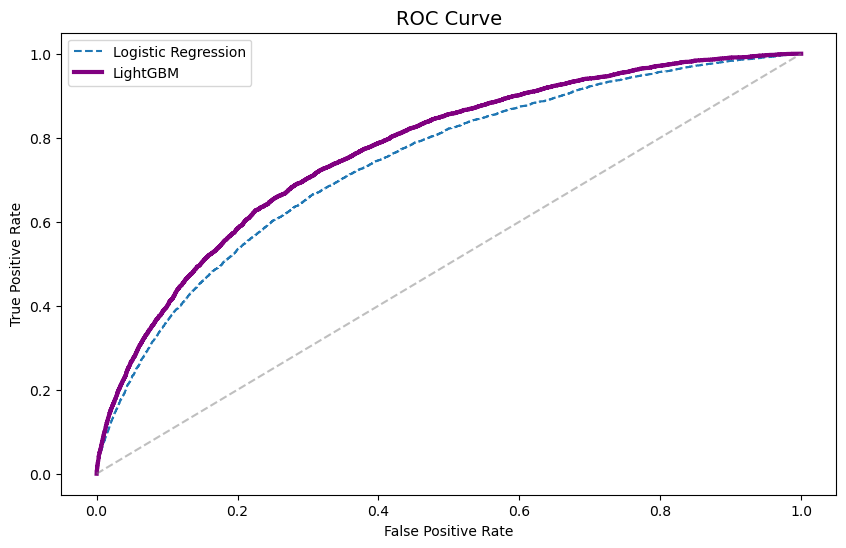

In [37]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(10, 6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_prob_lr) # fpr -> false positive rate
fpr_lgb , tpr_lgb, _ = roc_curve(y_test, y_test_prob_lgb)# tpr- > true positive rate
# parameters used for the curve
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression", linestyle="--")
plt.plot(fpr_lgb, tpr_lgb, label="LightGBM", linewidth=3, color="purple")
plt.plot([0,1], [0, 1],linestyle = "--", alpha=0.5,color="grey")
plt.title("ROC Curve", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## CatBoost - Best for many categorical features & reduces data leakage

### Training

In [38]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations = 1_000,
    learning_rate = 0.05,
    depth = 6,
    eval_metric = "Logloss",
    auto_class_weights="Balanced",
    random_seed = 42,
    verbose = 0
)
cat_model.fit(X_train,y_train)

### Testing

In [39]:
y_train_pred_cat = cat_model.predict(X_train)
y_test_pred_cat = cat_model.predict(X_test)

y_train_prob_cat = cat_model.predict_proba(X_train)[:,1]
y_test_prob_cat = cat_model.predict_proba(X_test)[:,1]

### Evalution

ROC - AUC Score :  0.7706955337758735
Recall Score :  0.6608257804632427
Precision Score :  0.1817023868859722
F1 Score :  0.285031708800278
Training Accuracy :  0.7323707786612035
Tresting Accuracy :  0.7323707786612035


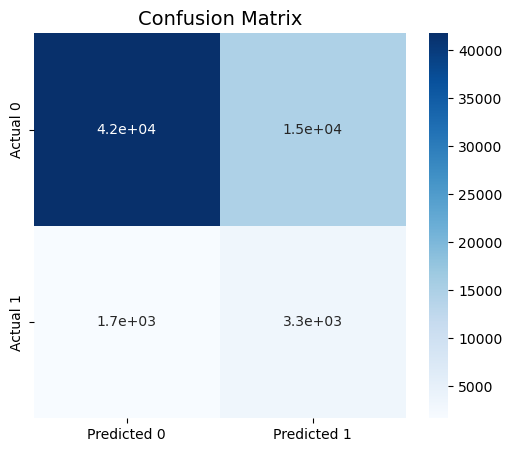

In [40]:
# ROC - AUC
print("ROC - AUC Score : ",roc_auc_score(y_test,y_test_prob_cat))
# Recall - To check if defaulters are not approved
print("Recall Score : ",recall_score(y_test,y_test_pred_cat))
# Precision - To check if repayers are not disapproved
print("Precision Score : ",precision_score(y_test,y_test_pred_cat))
# F1 Score
print("F1 Score : ",f1_score(y_test,y_test_pred_cat))
# Accuracy - to check for overfitting
print("Training Accuracy : ",accuracy_score(y_test,y_test_pred_cat))
print("Tresting Accuracy : ",accuracy_score(y_test,y_test_pred_cat))
# Confusion Matrix
cm = confusion_matrix(y_test,y_test_pred_cat)
plt.figure(figsize = (6,5))
sns.heatmap(cm,annot = True,cmap = "Blues",xticklabels=["Predicted 0","Predicted 1"],yticklabels=["Actual 0","Actual 1"])
plt.title("Confusion Matrix",fontsize=14)
plt.show()

## Comparsion between LogisticRegression and CatBoost

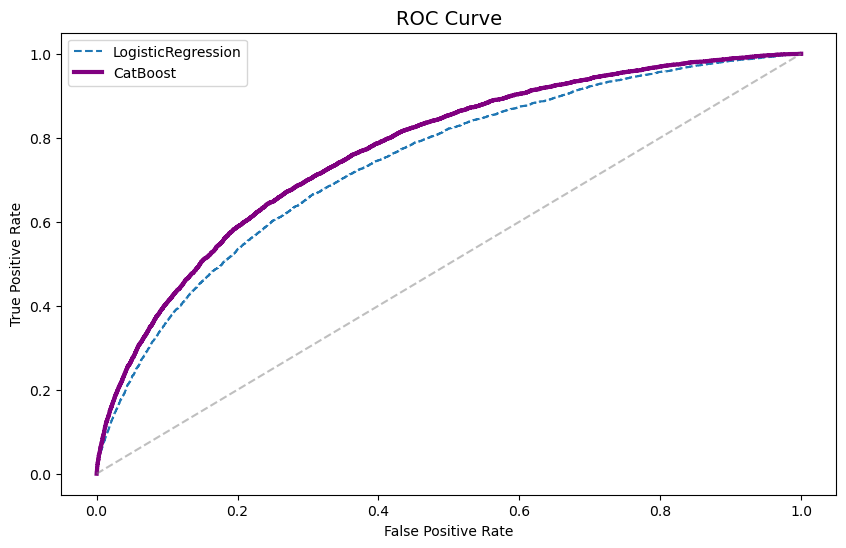

In [41]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(10, 6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_prob_lr) # fpr -> false positive rate
fpr_cat , tpr_cat, _ = roc_curve(y_test, y_test_prob_cat)# tpr- > true positive rate
# parameters used for the curve
plt.plot(fpr_lr, tpr_lr, label="LogisticRegression", linestyle="--")
plt.plot(fpr_cat, tpr_cat, label="CatBoost", linewidth=3, color="purple")
plt.plot([0,1], [0, 1],linestyle = "--", alpha=0.5,color="grey")
plt.title("ROC Curve", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Voting - Reduce Bias,Improve prediction stability & combines strengths of all three models

### Training 

In [42]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(
    estimators = [("xgb",xgb_model),("lgb",lgb_model),("cat",cat_model)],
    voting = "soft", # better as it averages the probability rather than majority votes
    weights = [1,1,1.5]
)
ensemble.fit(X1_train,y_train)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13193
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 221
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,estimators,"[('xgb', ...), ('lgb', ...), ...]"
,voting,'soft'
,weights,"[1, 1, ...]"
,n_jobs,None
,flatten_transform,True
,verbose,False
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


### Testing

In [43]:
y_train_pred_final = ensemble.predict(X1_train)
y_test_pred_final = ensemble.predict(X1_test)

y_train_prob_final = ensemble.predict_proba(X1_train)[:,1]
y_test_prob_final = ensemble.predict_proba(X1_test)[:,1]

### Evalution

ROC - AUC Score :  0.7726237363479338
Recall Score :  0.6708962739174219
Precision Score :  0.1830923981751223
F1 Score :  0.285031708800278
Training Accuracy :  0.731785441360584
Tresting Accuracy :  0.731785441360584


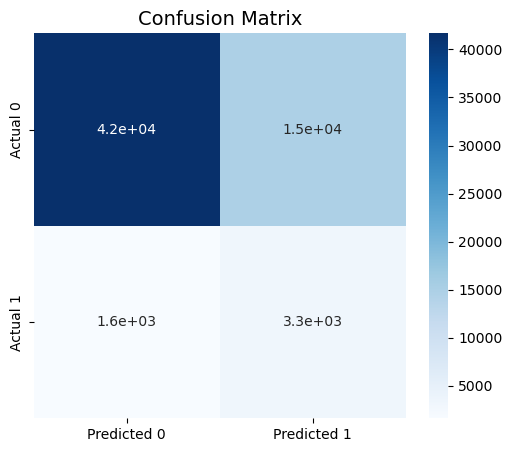

In [44]:
# ROC - AUC
print("ROC - AUC Score : ",roc_auc_score(y_test,y_test_prob_final))
# Recall - To check if defaulters are not approved
print("Recall Score : ",recall_score(y_test,y_test_pred_final))
# Precision - To check if repayers are not disapproved
print("Precision Score : ",precision_score(y_test,y_test_pred_final))
# F1 Score
print("F1 Score : ",f1_score(y_test,y_test_pred_cat))
# Accuracy - to check for overfitting
print("Training Accuracy : ",accuracy_score(y_test,y_test_pred_final))
print("Tresting Accuracy : ",accuracy_score(y_test,y_test_pred_final))
# Confusion Matrix
cm = confusion_matrix(y_test,y_test_pred_final)
plt.figure(figsize = (6,5))
sns.heatmap(cm,annot = True,cmap = "Blues",xticklabels=["Predicted 0","Predicted 1"],yticklabels=["Actual 0","Actual 1"])
plt.title("Confusion Matrix",fontsize=14)
plt.show()

## Classification into Risk Category

In [45]:
y_probs = y_test_prob_final
def risk_tier(prob):
    if prob < 0.3:
        return "Low Risk"
    elif prob < 0.6:
        return "Medium Risk"
    else:
        return "High Risk"

risk_categories = [risk_tier(p) for p in y_probs]

import pandas as pd
risk_df = pd.Series(risk_categories).value_counts()

print("Risk Tier Distribution:")
print(risk_df)

Risk Tier Distribution:
Medium Risk    25221
Low Risk       24907
High Risk      11375
Name: count, dtype: int64


# Section 5 : SHAP - CatBoost(Best Performed Model)

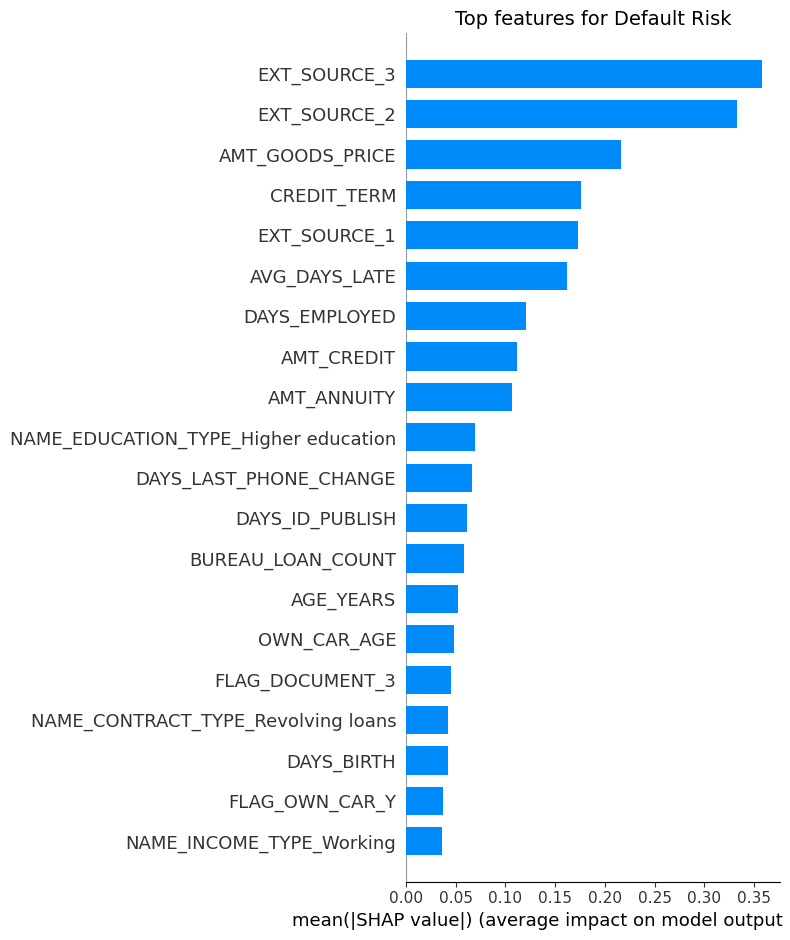

In [46]:
import shap
explainer = shap.TreeExplainer(cat_model)
# 1000 to understand the explainability clearly
X_test_sample = X_test.sample(n=1_000,random_state=42)
shap_values = explainer.shap_values(X_test_sample)
# the feature that matters the most (Global)
plt.figure(figsize=(6,4))
plt.title("Top features for Default Risk",fontsize=14)
shap.summary_plot(shap_values,X_test_sample,plot_type = "bar")
plt.show()

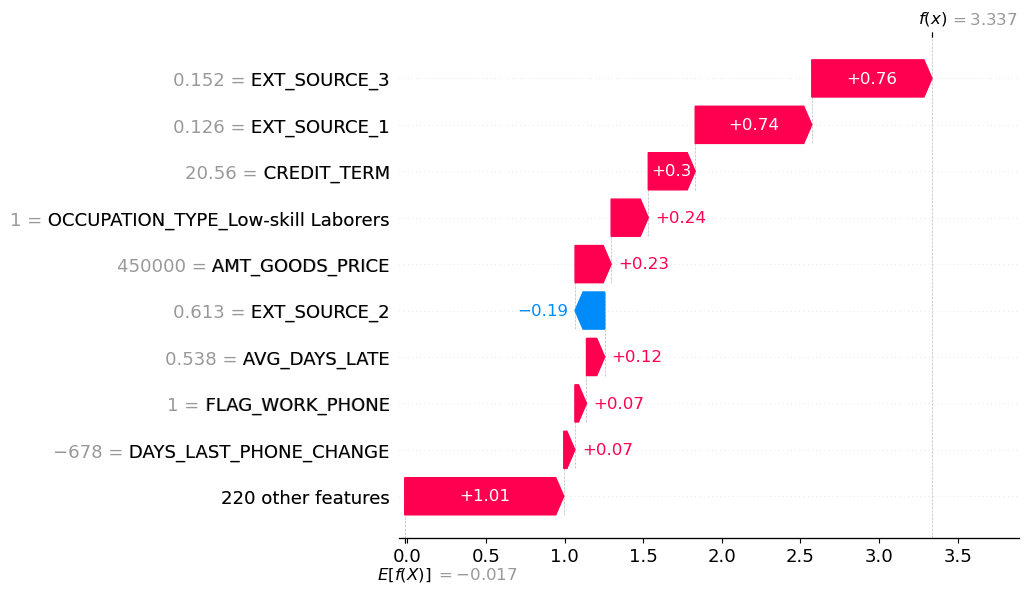


    === DECISION SUMMARY ===
    Applicant ID: 30675
    Decision:     REJECTED (High Risk)
    Confidence:   96.6% probability of default.

    Reasoning for Rejection:
    ------------------------
    1. External Credit History (Most Critical):
       The applicant's external score is 0.152. 
       Scores below 0.600 historically correlate with a 40%+ higher likelihood 
       of missed payments. This suggests financial instability recorded by other bureaus.

    2. Repayment Behavior:
       The applicant has an average delay of 0.5 days on previous installments.
       While this seems minor, our model penalizes any consistent lateness 
       as it indicates cash-flow management issues.

    3. Employment Stability:
       While 2.7 years of employment is generally stable, it was insufficient to offset this applicant's high external risk and repayment delays.
    


In [47]:
# local interpretability for the high-risk person
explainer = shap.TreeExplainer(cat_model)
shap_explanation = explainer(X_test)
y_prob_sample = cat_model.predict_proba(X_test)[:, 1]
high_risk_idx = np.argmax(y_prob_sample)
applicant_data = X_test.iloc[high_risk_idx]
plt.figure(figsize=(6,4))
shap.plots.waterfall(shap_explanation[high_risk_idx], show=False)
plt.show()
def explanation(probability, applicant_data):
    # 1. Determine Status
    status = "REJECTED" if probability > 0.5 else "APPROVED"
    risk_level = "High" if probability > 0.7 else ("Medium" if probability > 0.3 else "Low")
    
    # 2. Extract Key Values
    ext_score = applicant_data.get("EXT_SOURCE_3", 0)
    days_late = applicant_data.get("AVG_DAYS_LATE", 0)
    years_employed = abs(applicant_data.get('DAYS_EMPLOYED', 0)) / 365
    
    explanation = f"""
    === DECISION SUMMARY ===
    Applicant ID: {applicant_data.name}
    Decision:     {status} ({risk_level} Risk)
    Confidence:   {probability:.1%} probability of default.

    Reasoning for Rejection:
    ------------------------
    1. External Credit History (Most Critical):
       The applicant's external score is {ext_score:.3f}. 
       Scores below 0.600 historically correlate with a 40%+ higher likelihood 
       of missed payments. This suggests financial instability recorded by other bureaus.

    2. Repayment Behavior:
       The applicant has an average delay of {days_late:.1f} days on previous installments.
       While this seems minor, our model penalizes any consistent lateness 
       as it indicates cash-flow management issues.

    3. Employment Stability:
       While {years_employed:.1f} years of employment is generally stable, it was insufficient to offset this applicant's high external risk and repayment delays.
    """
    return explanation
print(explanation(y_prob_sample[high_risk_idx], applicant_data))

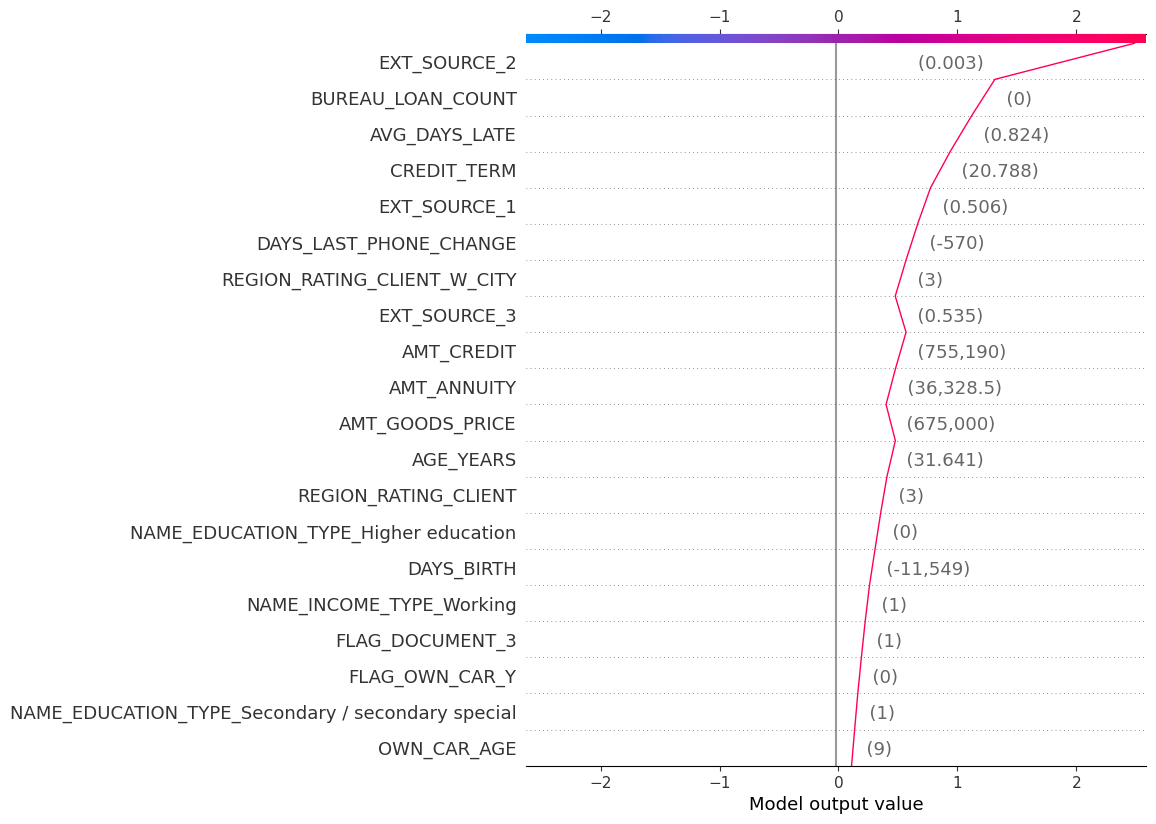

In [48]:
# decision plot for cummulative contribution of features
X_test_sample = X_test.sample(n=1_000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)
y_prob_sample = cat_model.predict_proba(X_test_sample)[:, 1]
high_risk_idx = np.argmax(y_prob_sample) 
shap.decision_plot(explainer.expected_value, shap_values[high_risk_idx],X_test_sample.iloc[high_risk_idx])

# SECTION 6 : Executive Summary

## Problem :
Traditional credit models:
- Miss behavioral risk patterns
- Fail unbanked applicants
- Lack decision transparency
- Struggle with class imbalance
## Our Solution :
Built an explainable ML pipeline that:
- Integrates alternative data (Bureau + Installments)
- Engineers behavioral features (AVG_DAYS_LATE, BUREAU_LOAN_COUNT)
- Handles imbalance using class weighting & ensemble learning
- Uses SHAP for transparent risk explanations
## Models Tested :
- Logistic Regression (Baseline)
- XGBoost,LightGBM,CatBoost (Boosting)
- Final Soft Voting Ensemble (Ensemble)
## Final Performance (Ensemble)
- Achieved an ROC-AUC of 0.772, a 15% improvement over our Logistic Regression baseline.
- We achieved a high Recall of 0.67 to capture 2/3 of potential defaulters. To mitigate the lower Precision (0.183), we utilize SHAP explanations to provide a 'Human-in-the-loop' review   process for borderline cases, ensuring fair treatment of applicants.
## Key Risk Drivers (SHAP)
- EXT_SOURCE scores (strongest predictors)
- Repayment delay behavior
- Bureau loan history
- Employment stability
Every rejected applicant can receive a clear risk explanation.